# DenseNet no fine tuning


In this run for the MobileNet, we froze all layers and added two dense layers after the conv_base.

Results>

Best Epoch: 87

test acc: 0.88533

test loss: 3.4204

f1_score: 0.887814

Precision: 0.887962

Recall: 0.88766

ROC AUC: 0.8878

---Training:  seconds --- 20690 s



In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Wed Jul 31 07:32:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   39C    P8              16W / 125W |    448MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 0
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [18]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [19]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [20]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [21]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [22]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [23]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [24]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [25]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [26]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [27]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [28]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [29]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [30]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [31]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [32]:
from keras.preprocessing.image import ImageDataGenerator
## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)

# train_datagen = ImageDataGenerator(
#     rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model Inception

In [33]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The MobileNet model




In [34]:
from keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [35]:
conv_base.summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

We will add a dense layer after our conv_base NN

In [36]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D

modelPreTMob = models.Sequential()
modelPreTMob.add(conv_base)

modelPreTMob.add(layers.AveragePooling2D())
modelPreTMob.add(layers.Flatten())
modelPreTMob.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTMob.add(BatchNormalization())
modelPreTMob.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTMob.add(layers.Dense(1, activation='sigmoid'))

In [37]:
modelPreTMob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0

In [38]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 zero_padding2d True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_1 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn True
3

In [39]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(conv_base.layers)

In [40]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTMob.trainable_weights))

This is the number of trainable weights before freezing the conv base: 368


In [41]:
# Freeze the initial layers in the convolutional base.
for model_layer in conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x000002A828DBA6A0>
FREEZING LAYER: <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002A828DF9220>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000002A828DDA2E0>
FREEZING LAYER: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A828DE12E0>
FREEZING LAYER: <keras.layers.core.activation.Activation object at 0x000002A828DDAC10>
FREEZING LAYER: <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002A828DE8100>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A828DEF6D0>
FREEZING LAYER: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A828DEF2E0>
FREEZING LAYER: <keras.layers.core.activation.Activation object at 0x000002A828DEF160>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000002A828DF7D00>
FREEZING LAYER: <keras.layers.normalization.batc

In [42]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [43]:
#conv_base.trainable = False

In [44]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(modelPreTMob.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [45]:
modelPreTMob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0

In [46]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [47]:
modelPreTMob.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [48]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelDenseNet-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [49]:
print(TrainingConfig.EPOCHS)

100


In [50]:
import time
start_time = time.time()

In [51]:
histPreT = modelPreTMob.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback]) 

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.3564 - accuracy: 0.8078
Epoch 1: val_accuracy improved from -inf to 0.86763, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelDenseNet-01-0.8676.keras
329/329 [==============================] - 247s 720ms/step - loss: 5.3564 - accuracy: 0.8078 - val_loss: 5.1282 - val_accuracy: 0.8676
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.1285 - accuracy: 0.8357
Epoch 2: val_accuracy improved from 0.86763 to 0.87368, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelDenseNet-02-0.8737.keras
329/329 [==============================] - 223s 679ms/step - loss: 5.1285 - accuracy: 0.8357 - val_loss: 4.9670 - val_accuracy: 0.8737
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 4.9747 - accuracy: 0.8439
Epoch 3: val_accuracy improved from 0.87368 to 0.88026, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesi

In [52]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 20609.674021720886 seconds ---


In [53]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [54]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [55]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_DenseNEt_FT0', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [56]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 87


In [57]:
START_PLOT_FROM_EPOCH= 1

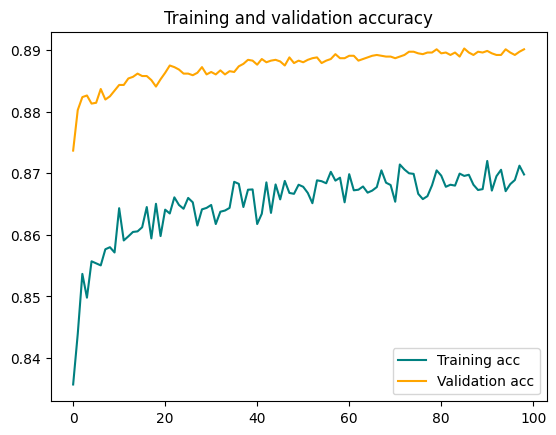

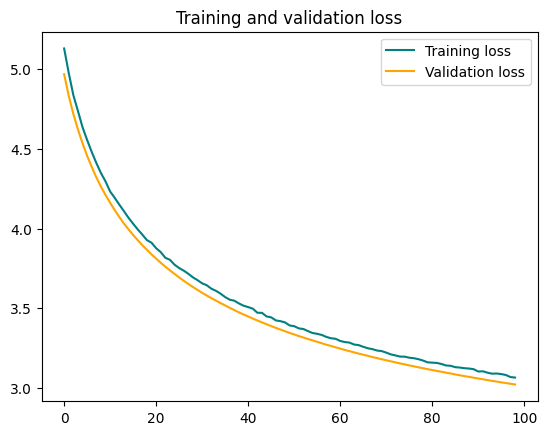

In [58]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, color='teal', label='Training acc')
plt.plot(epochs, val_acc, color='orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, color='teal', label='Training loss')
plt.plot(epochs, val_loss, color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [59]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 87


# Loading best epoch in our model using the checkpoints

In [60]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [61]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-87-0.8903.keras


In [62]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [63]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'ConvNextTiny_FT20-01-0.8195.keras',
 'ConvNextTiny_FT20-04-0.8350.keras',
 'ConvNextTiny_FT20-06-0.8462.keras',
 'ConvNextTiny_FT20-07-0.8566.keras',
 'ConvNextTiny_FT20-09-0.8584.keras',
 'ConvNextTiny_FT20-27-0.8608.keras',
 'ConvNextTiny_FT20-70-0.8611.keras',
 'model-01-0.8824.keras',
 'model-02-0.8867.keras',
 'model-03-0.8893.keras',
 'model-05-0.8895.keras',
 'model-06-0.8934.keras',
 'model-09-0.8961.keras',
 'model-11-0.8966.keras',
 'modelAlexNetFT10-01-0.8759.keras',
 'modelAlexNetFT10-02-0.8841.keras',
 'modelAlexNetFT10-06-0.8904.keras',
 'modelAlexNetFT10-08-0.8968.keras',
 'modelAlexNetFT10-13-0.8987.keras',
 'modelAlexNetFT10-14-0.9022.keras',
 'modelAlexNetFT10-24-0.9043.keras',
 'modelDenseNet-01-0.8676.keras',
 'modelDenseNet-02-0.8737.keras',
 'modelDenseNet-03-0.8803.keras',
 'modelDenseNet-04-0.8824.keras',
 'modelDenseNet-05-0.8826.keras',
 'modelDenseNet-08-0.8837.keras',
 'modelDenseNet-12-0.8843.keras',
 'modelDenseNet-14-0.8854.keras',
 

In [64]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelDenseNet-87-0.8903.keras') 
loaded_model.summary()

OSError: No file or directory found at modelMobileNetV2-56-0.8792.keras

## Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
start_time = time.time()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.EPOCHS,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 6000 images belonging to 2 classes.
60/60 [==============================] - 8s 108ms/step - loss: 3.4205 - accuracy: 0.8853
test acc: 0.8853333592414856
test loss: 3.420464515686035


In [ ]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 8.640947818756104 Training set > seconds ---


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [ ]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = modelPreTMob.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

4/4 [==============================] - 0s 36ms/step


In [ ]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2664,  336],
       [ 337, 2663]], dtype=int64)

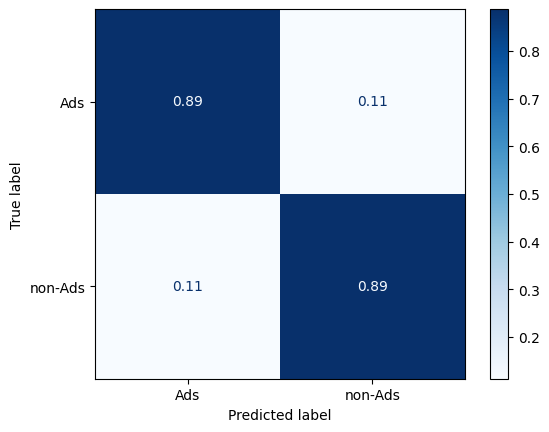

In [ ]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [ ]:

f1_score(true_labels, predicted_labels)

0.8878146357726288

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8879626542180727

In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.8876666666666667

In [ ]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.887833
